<a href="https://colab.research.google.com/github/bonareri/Cryptocurrency-Price-Prediction-/blob/main/Random_Forest_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade xgboost scikit-learn

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set seaborn style for better visualization
sns.set_style("darkgrid")

In [2]:
# Define the coin and its ticker (only Bitcoin)
COINS = {
    "bitcoin": "BTC-USD"
}

# Function to fetch historical price data
def fetch_crypto_data(coin_id, ticker):
    print(f"Fetching data for {coin_id.upper()}...")

    crypto = yf.Ticker(ticker)
    df = crypto.history(period="max")

    if df.empty:
        print(f"Error: No historical data found for {coin_id}.")
        return None

    # Format data
    df.reset_index(inplace=True)
    df["Date"] = pd.to_datetime(df["Date"]).dt.strftime('%Y-%m-%d')

    # Keep relevant columns
    df = df[["Date", "Close", "High", "Low", "Open", "Volume"]]

    return df

# Main function
def main():
    for coin_id, ticker in COINS.items():
        df = fetch_crypto_data(coin_id, ticker)
        if df is not None:
            filename = f"{coin_id}_prices.csv"
            df.to_csv(filename, index=False)
            print(f"Data saved to {filename}")

if __name__ == "__main__":
    main()

Fetching data for BITCOIN...
Data saved to bitcoin_prices.csv


In [3]:
#load csv
df = pd.read_csv('bitcoin_prices.csv', parse_dates=['Date'])

In [4]:
df.head()

,Date,Close,High,Low,Open,Volume
0,2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
1,2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2,2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
3,2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
4,2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100


In [5]:
df.tail()

,Date,Close,High,Low,Open,Volume
3803,2025-02-14,97508.968750,98819.468750,96342.804688,96623.367188,32697987277
3804,2025-02-15,97580.351562,97975.039062,97240.195312,97508.382812,17047266288
3805,2025-02-16,96175.031250,97725.593750,96060.976562,97580.492188,16536755396
3806,2025-02-17,95773.382812,97032.234375,95243.546875,96179.007812,27336550690
3807,2025-02-18,96467.414062,96467.414062,95146.312500,95774.218750,27547885568


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3808 entries, 0 to 3807
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3808 non-null   datetime64[ns]
 1   Close   3808 non-null   float64       
 2   High    3808 non-null   float64       
 3   Low     3808 non-null   float64       
 4   Open    3808 non-null   float64       
 5   Volume  3808 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 178.6 KB


## Data Preprocessing

In [7]:
# Step 1: Sort the data by Date
df = df.sort_values(by="Date")

# Step 2: Define the split ratio (80% train, 20% test)
train_size = int(len(df) * 0.8)

# Split the data into train and test (maintain temporal order)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Step 3: Define features (Open, High, Low, Volume) and target variable (Close)
X_train, y_train = train[["Open", "High", "Low", "Volume"]], train["Close"]
X_test, y_test = test[["Open", "High", "Low", "Volume"]], test["Close"]

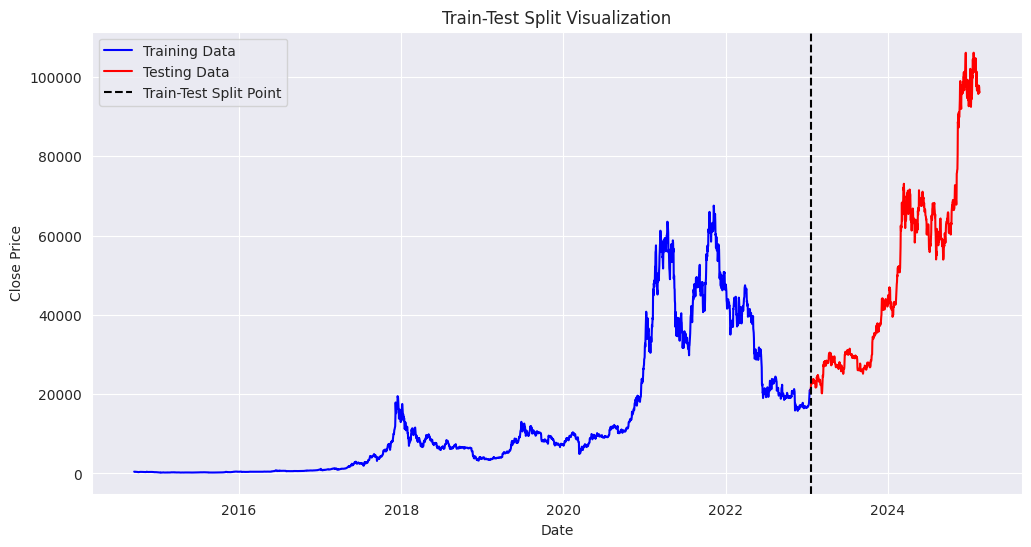

In [ ]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(train["Date"], train["Close"], label="Training Data", color="blue")
plt.plot(test["Date"], test["Close"], label="Testing Data", color="red")
plt.axvline(x=test["Date"].iloc[0], color="black", linestyle="--", label="Train-Test Split Point")

# Labels and title
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Train-Test Split Visualization")
plt.legend()
plt.show()

In [8]:
# Step 4: Min-Max Scaling for the features (but not the target variable)
scaler = MinMaxScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to DataFrame for readability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=["Open", "High", "Low", "Volume"])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=["Open", "High", "Low", "Volume"])

# Step 5: Check the shapes of the data
print(f"Train size: {X_train_scaled.shape}, Test size: {X_test_scaled.shape}")

Train size: (3046, 4), Test size: (762, 4)


## Modelling

### Random Forest

In [14]:
rf_model = RandomForestRegressor(
    n_estimators=200,       # Number of decision trees in the forest
    max_depth=10,           # Maximum depth of each tree to prevent overfitting
    max_features='sqrt',    # Number of features to consider for splitting at each node
    random_state=42         # Ensures reproducibility
)

In [15]:
#Train the model on the training data
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=200,
                      random_state=42)

In [16]:
# Step 3: Predict on the test data
y_pred = rf_model.predict(X_test_scaled)

In [17]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
rmse = mse**0.5  # Compute RMSE manually by taking the square root of MSE
r2 = r2_score(y_test, y_pred)  # R-squared (Goodness of fit)

In [18]:
# Print evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 4905.28
Mean Squared Error (MSE): 136436813.84
Root Mean Squared Error (RMSE): 11680.62


In [19]:
# Random Forest provides feature importances
feature_importances = rf_model.feature_importances_

<ipython-input-20-13b2a4e7d82a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=X_train.columns, y=feature_importances, palette="Blues_d")


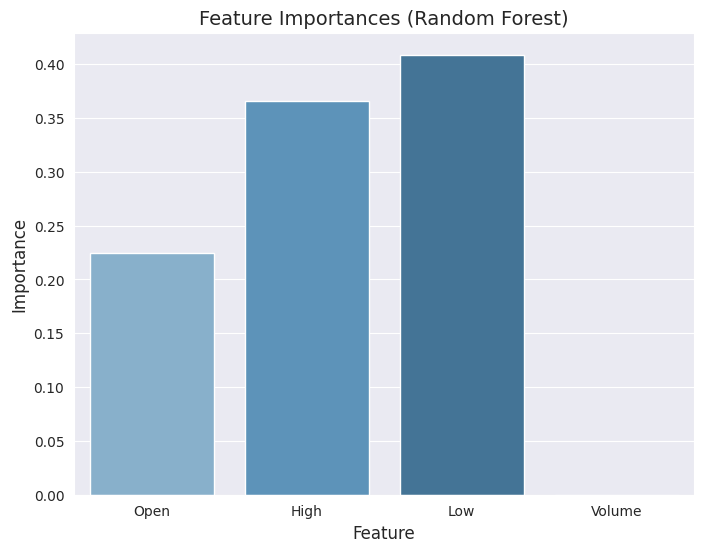

In [20]:
# Plot the feature importances
plt.figure(figsize=(8, 6))
sns.barplot(x=X_train.columns, y=feature_importances, palette="Blues_d")
plt.title("Feature Importances (Random Forest)", fontsize=14)
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Importance", fontsize=12)
plt.show()

### 📊 Visualize Predictions

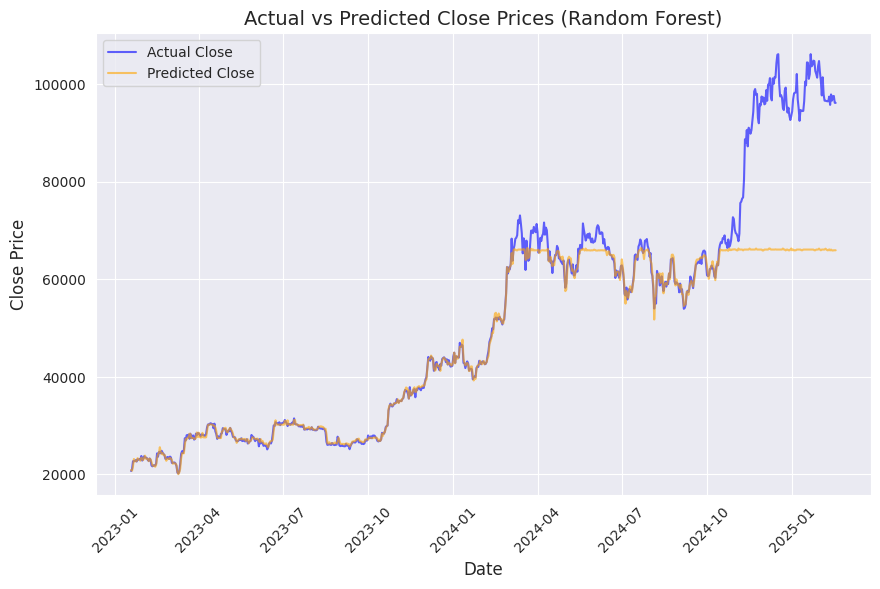

In [ ]:
# Step 6: Visualize the predictions vs actual values
plt.figure(figsize=(10, 6))

# Ensure that the test data uses 'Date' as the index
plt.plot(test['Date'], y_test, label="Actual Close", color="blue", alpha=0.6)  # Using 'Date' for x-axis
plt.plot(test['Date'], y_pred, label="Predicted Close", color="orange", alpha=0.6)  # Using 'Date' for x-axis

# Chart formatting
plt.title("Actual vs Predicted Close Prices (Random Forest)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.xticks(rotation=45)  # Rotate the date labels for better readability
plt.legend()
plt.grid(True)
plt.show()

## XGBoost

In [27]:
# Initialize the XGBoost model
xgb_model = XGBRegressor(
    n_estimators=200,        # Number of boosting rounds (trees)
    learning_rate=0.05,      # Step size shrinkage to prevent overfitting
    max_depth=7,             # Maximum depth of each tree
    reg_lambda=0.5,          # L2 regularization (ridge)
    random_state=42
)

In [28]:
# Train the model
xgb_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [29]:
# Make predictions on the test data
y_pred_xgb = xgb_model.predict(X_test_scaled)

In [30]:
#Evaluate the model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)  # Mean Absolute Error
mse_xgb = mean_squared_error(y_test, y_pred_xgb)  # Mean Squared Error
rmse_xgb = mse_xgb**0.5  # Root Mean Squared Error (manual calculation)
r2_xgb = r2_score(y_test, y_pred_xgb)  # R-squared (Goodness of fit)

In [31]:
# Print evaluation metrics
print(f"XGBoost - Mean Absolute Error (MAE): {mae_xgb:.2f}")
print(f"XGBoost - Mean Squared Error (MSE): {mse_xgb:.2f}")
print(f"XGBoost - Root Mean Squared Error (RMSE): {rmse_xgb:.2f}")

XGBoost - Mean Absolute Error (MAE): 5755.23
XGBoost - Mean Squared Error (MSE): 156699068.39
XGBoost - Root Mean Squared Error (RMSE): 12517.95


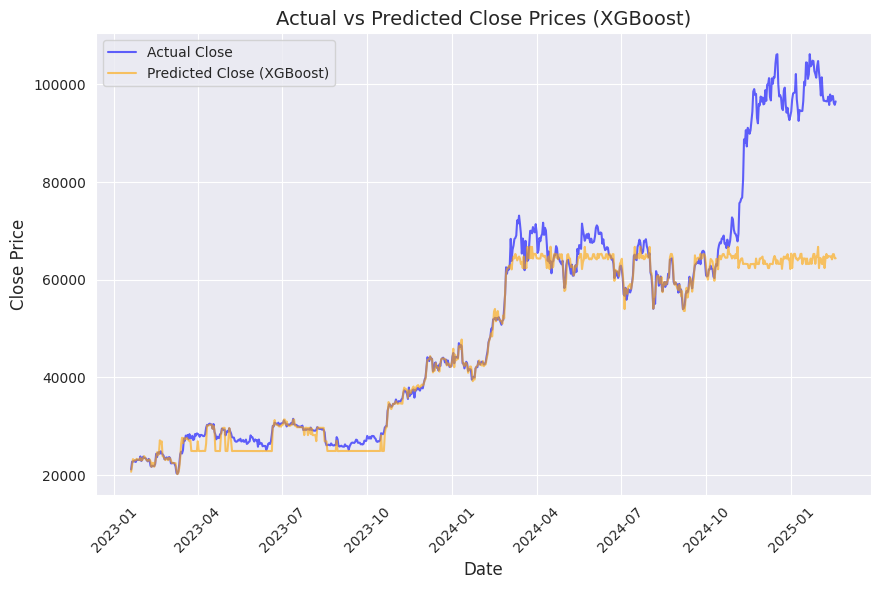

In [32]:
# Visualize the predictions vs actual values
plt.figure(figsize=(10, 6))

# Plot actual vs predicted for XGBoost
plt.plot(test['Date'], y_test, label="Actual Close", color="blue", alpha=0.6)
plt.plot(test['Date'], y_pred_xgb, label="Predicted Close (XGBoost)", color="orange", alpha=0.6)

# Chart formatting
plt.title("Actual vs Predicted Close Prices (XGBoost)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.xticks(rotation=45)  # Rotate the date labels for better readability
plt.legend()
plt.grid(True)
plt.show()

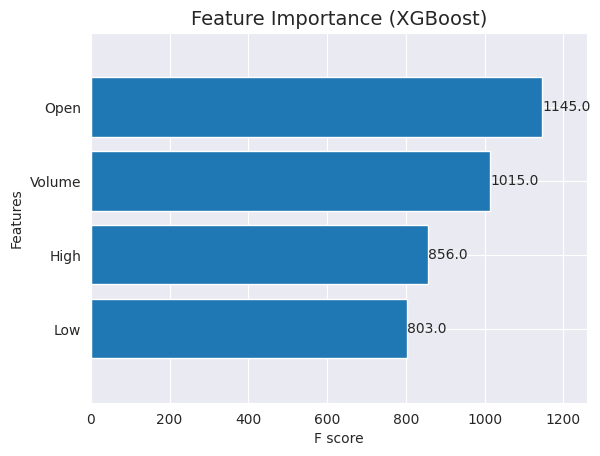

In [ ]:
# Feature Importance Visualization
# Plot the feature importance
xgb.plot_importance(xgb_model, importance_type="weight", max_num_features=10, height=0.8)
plt.title("Feature Importance (XGBoost)", fontsize=14)
plt.show()

### Hyperparameter Tuning

In [ ]:
# Define the parameter distribution for Random Forest
param_dist_rf = {
    'n_estimators': [100, 200, 300, 500],                # Number of trees
    'max_depth': [None, 10, 20, 30, 50],                  # Max depth of trees
    'min_samples_split': [2, 5, 10],                       # Min samples to split internal nodes
    'min_samples_leaf': [1, 2, 4],                         # Min samples at leaf nodes
    'max_features': ['auto', 'sqrt', 'log2'],             # Number of features to consider for split
    'bootstrap': [True, False]                             # Whether bootstrap samples are used
}

In [ ]:
# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

In [ ]:
# Step 1: Setup RandomizedSearchCV
random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist_rf,
                                      n_iter=50, cv=3, scoring='neg_mean_squared_error',
                                      n_jobs=-1, verbose=2, random_state=42)

In [ ]:
# Step 2: Fit the model using RandomizedSearchCV
random_search_rf.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
51 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 50],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 500]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [ ]:
# Step 3: Print the best parameters found
print(f"Best Parameters (Random Forest): {random_search_rf.best_params_}")

Best Parameters (Random Forest): {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': False}


In [ ]:
# Step 4: Evaluate the tuned model
best_rf_model = random_search_rf.best_estimator_

In [ ]:
# Make predictions with the tuned model
y_pred_rf = best_rf_model.predict(X_test_scaled)

In [ ]:
# Calculate evaluation metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mse_rf**0.5
r2_rf = r2_score(y_test, y_pred_rf)

In [ ]:
# Print evaluation metrics
print(f"Random Forest Tuned - Mean Absolute Error (MAE): {mae_rf:.2f}")
print(f"Random Forest Tuned - Mean Squared Error (MSE): {mse_rf:.2f}")
print(f"Random Forest Tuned - Root Mean Squared Error (RMSE): {rmse_rf:.2f}")
print(f"Random Forest Tuned - R-squared (R2): {r2_rf:.2f}")

Random Forest Tuned - Mean Absolute Error (MAE): 4867.97
Random Forest Tuned - Mean Squared Error (MSE): 133886339.58
Random Forest Tuned - Root Mean Squared Error (RMSE): 11570.93
Random Forest Tuned - R-squared (R2): 0.77
